In [1]:
# Authors: A07 Section

In [2]:
#!pip3 install fastfuels==1.0.2 --user

In [3]:
import fastfuels
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import rasterio
import rasterio.mask
from shapely import geometry
import geopandas as gpd
from fiona import crs

In [5]:
from scipy import stats

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
#src=rasterio.open(r'LF2021_FBFM40_210_CONUS/LF2021_FBFM40_210_CONUS/Tif/LC21_F40_210.tif')
src=rasterio.open('LC21_F40_210.tif')

print(type(src))
print(src.block_shapes)
display(src.files)
print(src.is_tiled)

<class 'rasterio.io.DatasetReader'>
[(128, 128)]


['LC21_F40_210.tif']

True


In [8]:
#original numbers:
# minx, miny = -122.0003, 45
# maxx, maxy = -122, 45.0003

minx, miny = -121.806464, 38.126339
maxx, maxy = -121.806164, 38.126639

bbox = geometry.box(minx, miny, maxx, maxy)

geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=crs.from_epsg(4326))  #Word Geodetic System 1984

print(geo)

                                            geometry
0  POLYGON ((-121.80616 38.12634, -121.80616 38.1...


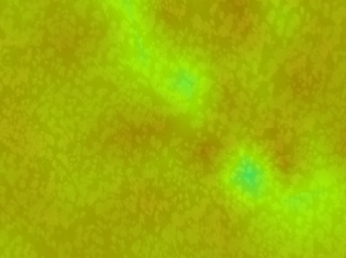
<div align="center">(Forest area with fastfuels sav layered over)<div>

                                            geometry
0  POLYGON ((-2213370.933 1979364.929, -2213361.9...


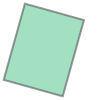

In [9]:
geo_utm=geo.to_crs(crs=src.crs.data)
print(geo_utm)
display(geo_utm.loc[0,"geometry"])

In [10]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]
coords=getFeatures(geo_utm)
display(coords)

[{'type': 'Polygon',
  'coordinates': [[[-2213370.9326172518, 1979364.9285774315],
    [-2213361.9134944724, 1979397.321777114],
    [-2213387.008522878, 1979404.3089388362],
    [-2213396.0277479156, 1979371.9157676257],
    [-2213370.9326172518, 1979364.9285774315]]]}]

In [11]:
out_img, out_transform = rasterio.mask.mask(src, shapes=coords, crop=True)

In [12]:
print(np.unique(out_img))

[  102 32767]


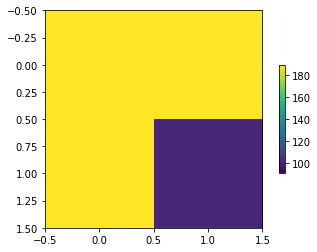

In [13]:
fig,ax=plt.subplots()

h=ax.imshow(out_img[0,:,:], origin="upper", vmin=91., vmax=189.)
fig.colorbar(h, shrink=0.5)

Mapped data values align with the fastfuels classification of TL5, High load conifer litter, light slash or dead fuel, spread rate and flame low.

In [14]:
fio = fastfuels.open('https://wifire-data.sdsc.edu:9000/fastfuels/index.fio', ftype='s3')
fio.cache_limit = 1e14

In [15]:
roi = fio.query(-122.0003, 45, 15)
# roi.view('sav')

Bounding box query found in single source: or_set/or_38.fio


In [16]:
print(roi.get_properties())

['bulk_density', 'sav', 'moisture', 'fuel_depth', 'elevation']


In [17]:
# roi = fio.query(minx, miny, 30)
# roi.view('bulk_density')

In [18]:
raw_sav_data = roi.data_dict['sav']
raw_moisture_data = roi.data_dict['moisture']
raw_elevation_data = roi.data_dict['elevation']
raw_bd_data = roi.data_dict['bulk_density']

In [19]:
raw_sav_data.shape

(30, 30, 128)

In [20]:
pixels = []
for x in range(len(raw_sav_data)):
    for y in raw_sav_data[x]:
        avg = y.mean()
        pixels.append(avg)

In [21]:
import pandas as pd
df = pd.DataFrame()
df['Pix'] = pixels

<AxesSubplot:>

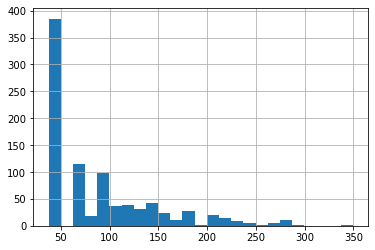

In [22]:
df['Pix'].hist(bins=25)

In [23]:
df[df['Pix']<50].shape[0]/df.shape[0]

0.42777777777777776

In [24]:
#helper function from above
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [25]:
def analyze_location_wilson(lon, lat):
    
    src=rasterio.open('LC21_F40_210.tif')
    
    output = []

    minx, miny = lat, lon
    maxx, maxy = lat + 0.0003, lon + 0.0003

    bbox = geometry.box(minx, miny, maxx, maxy)

    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=crs.from_epsg(4326))  #Word Geodetic System 1984
    geo_utm=geo.to_crs(crs=src.crs.data)
    coords=getFeatures(geo_utm)
    out_img, out_transform = rasterio.mask.mask(src, shapes=coords, crop=True)
    
    output.append(np.unique(out_img)[0])
    fig,ax=plt.subplots(1,2)

    h=ax[0].imshow(out_img[0,:,:], origin="upper", vmin=91., vmax=189.)
    fig.colorbar(h, shrink=0.5)
    
    roi = fio.query(lat, lon, 15)
    # print(roi.view('sav'))
    raw_sav_data = roi.data_dict['sav']
    
    pixels = []
    
#     for x in range(len(raw_sav_data)):
#         heights = 0
#         for y in range(len(raw_sav_data)):
#             sum_of_heights = heights + sum(raw_sav_data[x][y])
#             pixels.append(sum_of_heights)

    for x in range(len(raw_sav_data)):
        for y in raw_sav_data[x]:
            sum_of_heights = y.sum()
            pixels.append(sum_of_heights)
            
    df = pd.DataFrame()
    df['Pix'] = pixels
    print(df['Pix'].hist())
    
    output.append([sum(pixels)/len(pixels)])#(df[df['Pix'] < 20].shape[0] / df.shape[0] * 100)
    
    print('The label for this region is ' + str(output[0]))
    print('The sum of non-flat surface in this region is ' + str(output[1]))
    return pixels #raw_sav_data

In [26]:
def analyze_location(lon, lat):
    
    src=rasterio.open('LC21_F40_210.tif')
    
    output = []

    minx, miny = lat, lon
    maxx, maxy = lat + 0.0003, lon + 0.0003

    bbox = geometry.box(minx, miny, maxx, maxy)

    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=crs.from_epsg(4326))  #Word Geodetic System 1984
    geo_utm=geo.to_crs(crs=src.crs.data)
    coords=getFeatures(geo_utm)
    out_img, out_transform = rasterio.mask.mask(src, shapes=coords, crop=True)
    
    output.append(np.unique(out_img)[0])
    fig,ax=plt.subplots(1,2)

    h=ax[0].imshow(out_img[0,:,:], origin="upper", vmin=91., vmax=189.)
    fig.colorbar(h, shrink=0.5)
    
    roi = fio.query(lat, lon, 15)
    raw_sav_data = roi.data_dict['sav']
    
    tree_label = []
    for x in raw_sav_data:
        for y in x:
            plt.hist(y)
            if any(y[2:] != 0):
                tree_label.append(True)
            else:
                tree_label.append(False)
            
    #output.append([sum(pixels)/len(pixels)])#(df[df['Pix'] < 20].shape[0] / df.shape[0] * 100)
    
#    print('The label for this region is ' + str(output[0]))
#    print('The proportion of non-flat surface in this region is ' + str(sum(tree_label) / len(tree_label)))
    return output[0]

### PCA

In [27]:
from sklearn.decomposition import PCA

In [28]:
def dimensionality_reduction(lat, lon):

    roi = fio.query(lon, lat, 15)
    raw_sav_data = roi.data_dict['sav']
        
    reduced = []
    
    for i in range(raw_sav_data.shape[0]):
        pca = PCA(n_components=1)
        pca_val = pca.fit_transform(raw_sav_data[i])
        #print(pca.explained_variance_ratio_)
        reduced.append((pca_val).mean())
    
    table = pd.DataFrame()
    table['numbers'] = reduced
    
    return [table['numbers'].mean(), table['numbers'].std()]

In [30]:
dimensionality_reduction(45, -122.0003) # forest

Bounding box query found in single source: or_set/or_38.fio


[2.015855352510698e-05, 7.224524597404525e-05]

Described as ' High load conifer litter, light slash or dead fuel, spread rate and flame low'

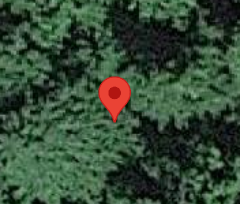

In [32]:
dimensionality_reduction(38.126339, -121.806464) # desert

Bounding box query found in single source: ca_set/ca_74.fio


[0.001953125, 0.0]

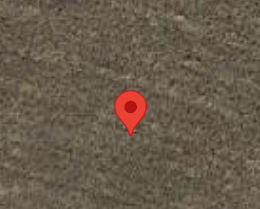

In [34]:
dimensionality_reduction(32.938576, -116.684257) #grass

Bounding box query found in single source: ca_set/ca_238.fio


[0.001953125, 0.0]

' Low load, dry climate grass primarily grass with some small amounts of fine, dead fuel, any shrubs do not affect fire behavior'

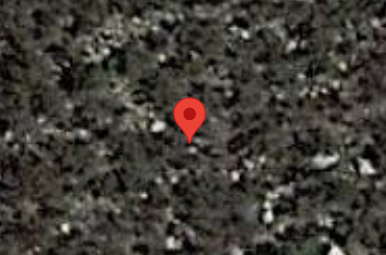

In [36]:
dimensionality_reduction(32.885801, -116.873526) #grass shrub

Bounding box query found in single source: ca_set/ca_237.fio


[0.00048828125, 0.0]

' Moderate load, dry climate grass-shrub, shrubs are 1-3 feet high, grass load moderate, spread rate high, and flame length is moderate'

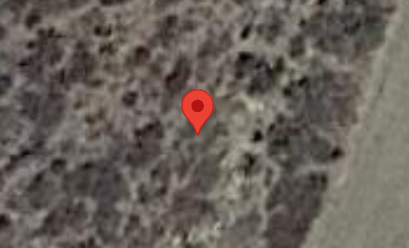

In [38]:
dimensionality_reduction(32.783077, -116.953164) #urban

Bounding box query found in single source: ca_set/ca_237.fio


[4.238551287727432e-09, 1.1798318411138098e-07]

' Urban/Developed'

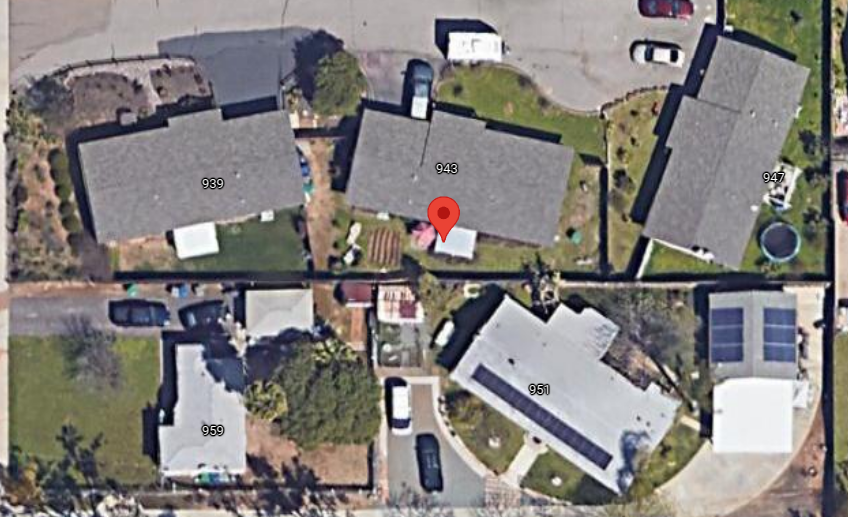

In [40]:
dimensionality_reduction( 39.151537, -120.010631 ) #Lake Tahoe

choosing ca_set/ca_84.fio


[0.0, 0.0]

' Open Water'

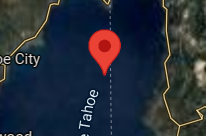

In [42]:
dimensionality_reduction( 38.989042, -120.579882 ) #forest in Lake Tahoe

Bounding box query found in single source: ca_set/ca_81.fio


[1.3393827430263627e-05, 9.514291741652414e-05]

' Moderate load broadleaf litter, spread rate and flame moderate'

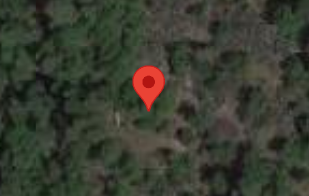

In [44]:
dimensionality_reduction( 35.19249951084869, -119.86643957481108 ) # CARRIZO PLAIN NATIONAL MONUMENT grassland

Bounding box query found in single source: ca_set/ca_144.fio


[0.001953125, 0.0]

' Low load, dry climate grass primarily grass with some small amounts of fine, dead fuel, any shrubs do not affect fire behavior'

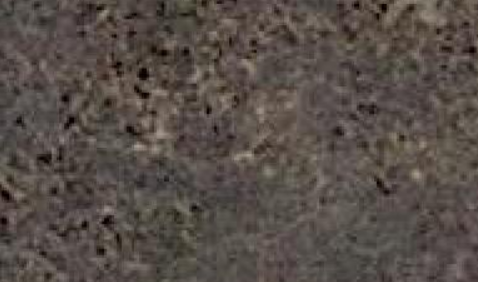

In [46]:
dimensionality_reduction( 38.02801271624672, -122.79131373964572 ) # Northern California shrublands

Bounding box query found in single source: ca_set/ca_69.fio


[8.274774359051662e-07, 0.00010762122110463679]

' Very high load, dry climate timber shrub, heavy forest litter with shrub or small tree understory, spread rate and flame moderate'

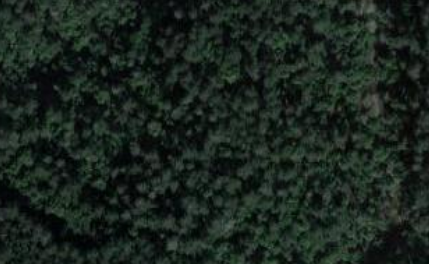

In [48]:
dimensionality_reduction( 38.48352662411673, -123.14313953065052 ) # coastal forest

Bounding box query found in single source: ca_set/ca_68.fio


[0.001953125, 0.0]

# Dimension Reduction Section

### Aggregation of sav columns

In [49]:
lat, lon = 38.48352662411673, -123.14313953065052

In [50]:
roi = fio.query(lon, lat, 15)
raw_sav_data = roi.data_dict['sav']

Bounding box query found in single source: ca_set/ca_68.fio


In [51]:
def aggregate_column_stats(lat, lon):

    roi = fio.query(lat, lon, 15)
    stats = {}
        
    for key, value in roi.data_dict.items():
        aggregated = []
        for x in value:
            temp = []
            current_stats = {}
            for y in x:
                # measures of central tendency
                current_stats['average'] = np.mean(y)
                current_stats['median'] = np.median(y)
                temp.append(current_stats)
            aggregated.append(temp)
        stats[key] = aggregated
    return stats

In [52]:
aggregate_column_stats( -123.14313953065052, 38.48352662411673 )

Bounding box query found in single source: ca_set/ca_68.fio


{'bulk_density': [[{'average': 0.0018382354, 'median': 0.0},
   {'average': 0.0018382354, 'median': 0.0},
   {'average': 0.0018382354, 'median': 0.0},
   {'average': 0.0018382354, 'median': 0.0},
   {'average': 0.0018382354, 'median': 0.0},
   {'average': 0.0018382354, 'median': 0.0},
   {'average': 0.0018382354, 'median': 0.0},
   {'average': 0.0018382354, 'median': 0.0},
   {'average': 0.0018382354, 'median': 0.0},
   {'average': 0.0018382354, 'median': 0.0},
   {'average': 0.0018382354, 'median': 0.0},
   {'average': 0.0018382354, 'median': 0.0},
   {'average': 0.0018382354, 'median': 0.0},
   {'average': 0.0018382354, 'median': 0.0},
   {'average': 0.0018382354, 'median': 0.0},
   {'average': 0.0018382354, 'median': 0.0},
   {'average': 0.0018382354, 'median': 0.0},
   {'average': 0.0018382354, 'median': 0.0},
   {'average': 0.0018382354, 'median': 0.0},
   {'average': 0.0018382354, 'median': 0.0},
   {'average': 0.0018382354, 'median': 0.0},
   {'average': 0.0018382354, 'median': 

# Using Landfire API to Loop for GPS Coordinates

In [29]:
def conversion(old):
    direction = {'N':1, 'S':-1, 'E': 1, 'W':-1}
    new = old.replace(u'°',' ').replace('\'',' ').replace('"',' ')
    new = new.split()
    new_dir = new.pop()
    new.extend([0,0,0])
    return (int(new[0])+int(new[1])/60.0+int(new[2])/3600.0) * direction[new_dir]

lat, lon = u'''38°13'660"N, 80°19'000"W'''.split(', ')
print (conversion(lat), conversion(lon))

38.4 -80.31666666666666


In [30]:
lat = 38
long = -100 # [-86, -116]

list_coord = []
for lon in range(-106*10, -96*10):
    for lat in range(32*10, 46*10):
        list_coord.append([lat/10, lon/10])

len(list_coord)

14000

In [68]:
# grass = []
# forest = []
# counter = 0
# for coord in list_coord[100:200]:
#     print(counter)
#     counter += 1
#     fuel_type = analyze_location(coord[0], coord[1])
#     if (101 <= fuel_type <= 124):
#         grass.append(coord)
#     elif (161 <= fuel_type <= 189):
#         forest.append(coord)


0
choosing tx_set/tx_96.fio
1
choosing tx_set/tx_96.fio
2
choosing tx_set/tx_96.fio
3
Bounding box query found in single source: nm_set/nm_103.fio
4
Bounding box query found in single source: nm_set/nm_103.fio
5
Bounding box query found in single source: nm_set/nm_103.fio
6
Bounding box query found in single source: nm_set/nm_103.fio
7
Bounding box query found in single source: nm_set/nm_103.fio
8
Bounding box query found in single source: nm_set/nm_103.fio
9
Bounding box query found in single source: nm_set/nm_103.fio
10
Bounding box query found in single source: nm_set/nm_87.fio
11
Bounding box query found in single source: nm_set/nm_87.fio
12
Bounding box query found in single source: nm_set/nm_88.fio
13
Bounding box query found in single source: nm_set/nm_88.fio
14
Bounding box query found in single source: nm_set/nm_88.fio
15
Bounding box query found in single source: nm_set/nm_88.fio
16
Bounding box query found in single source: nm_set/nm_88.fio
17
Bounding box query found in sin

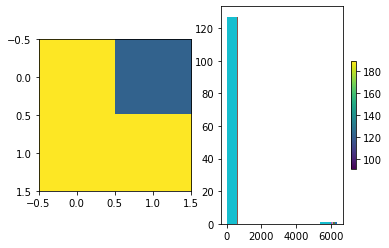

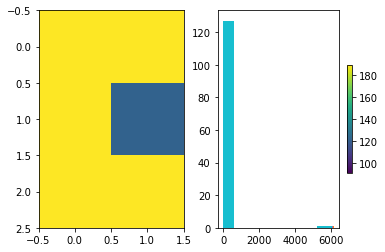

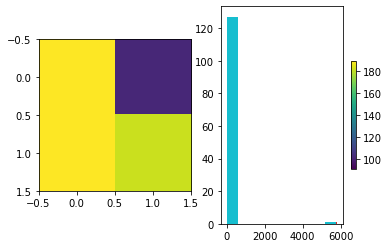

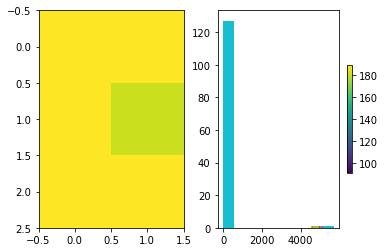

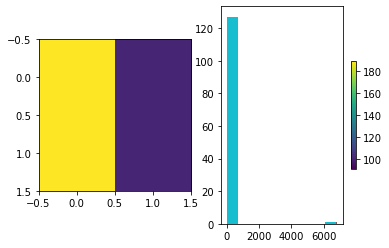

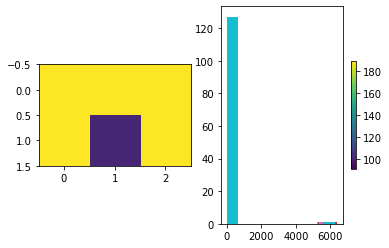

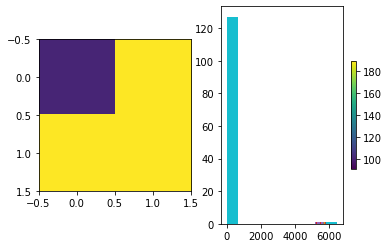

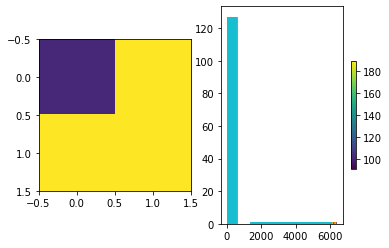

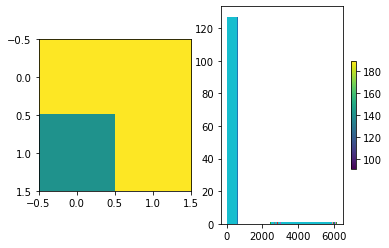

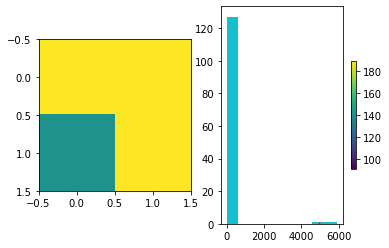

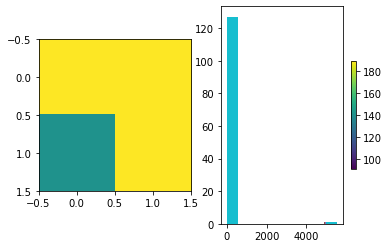

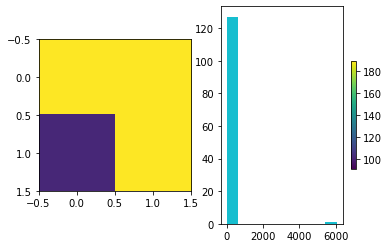

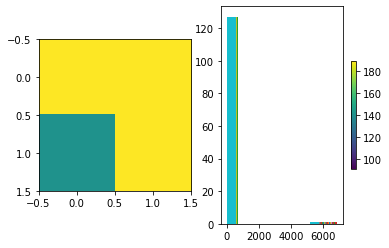

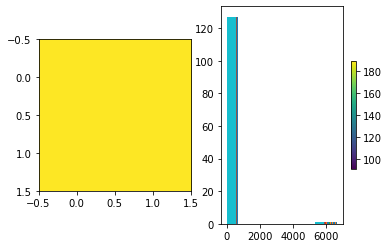

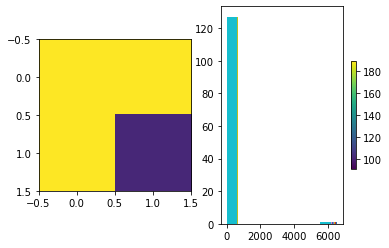

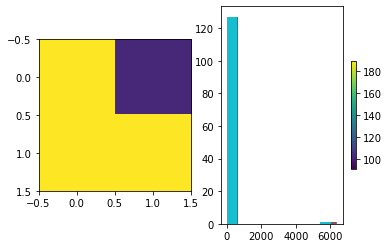

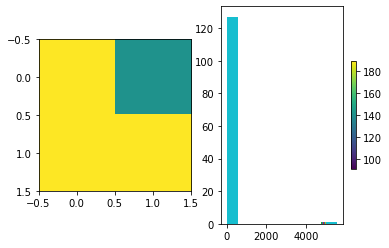

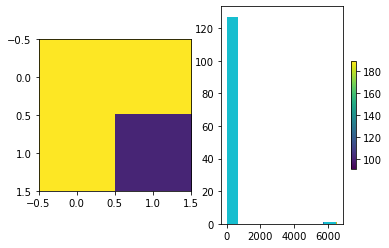

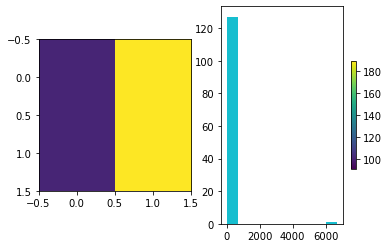

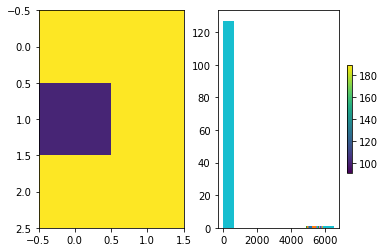

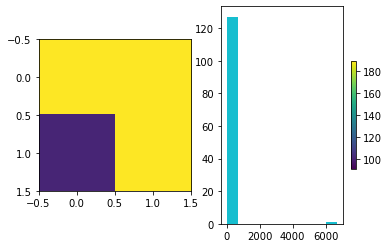

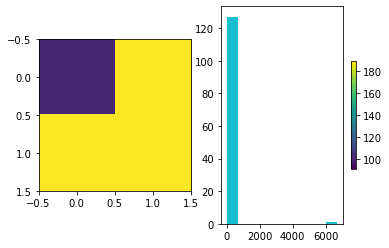

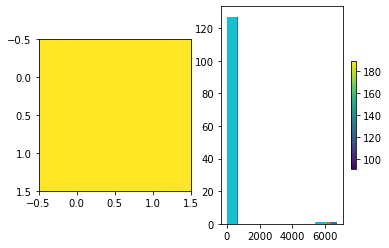

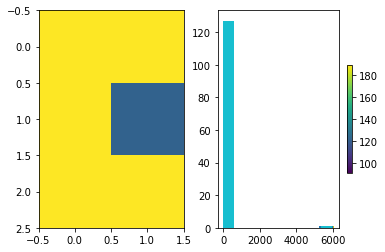

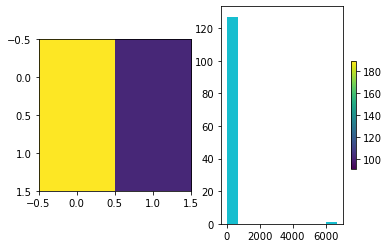

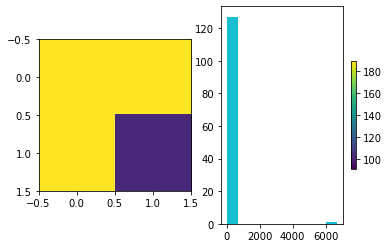

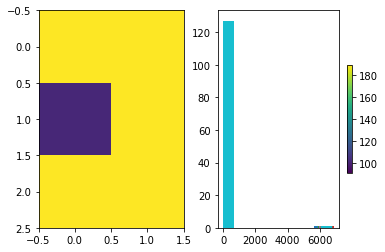

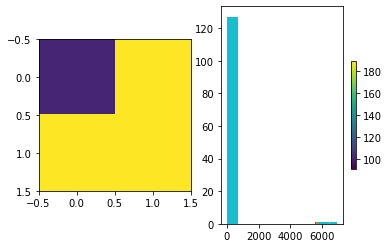

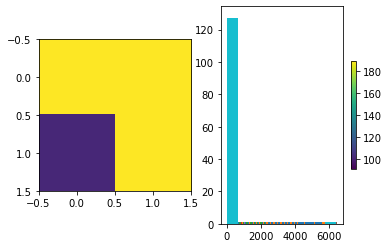

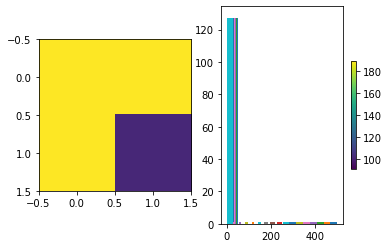

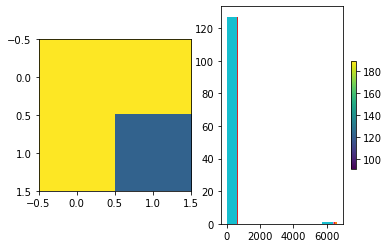

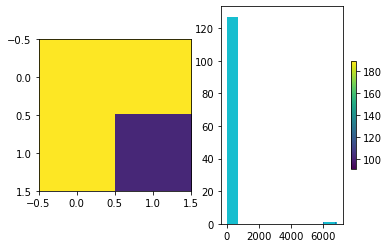

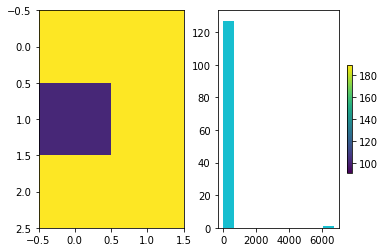

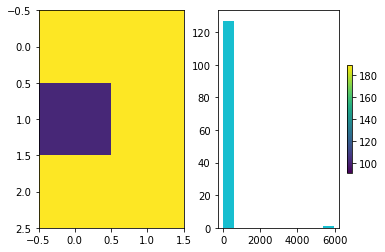

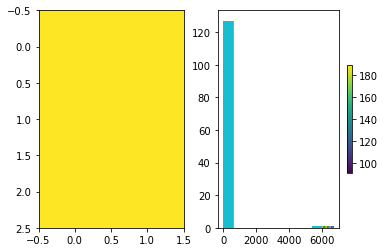

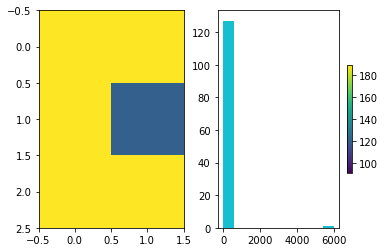

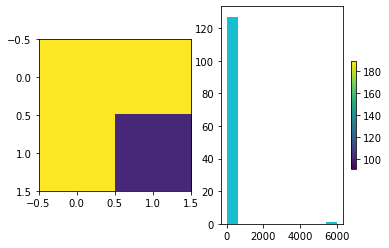

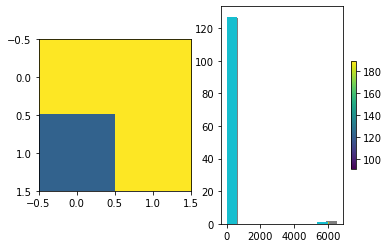

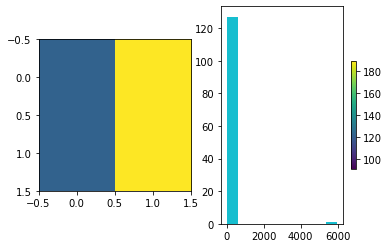

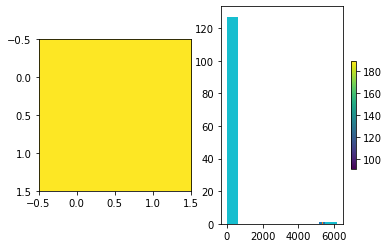

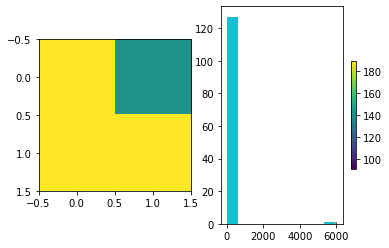

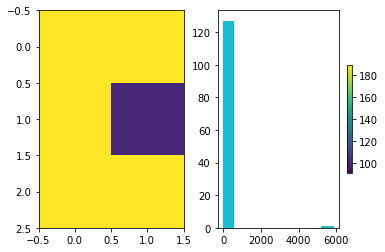

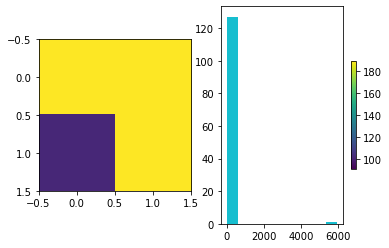

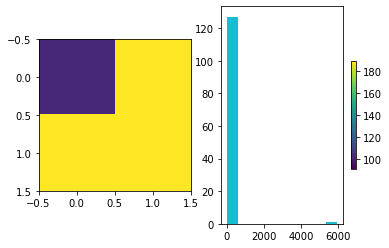

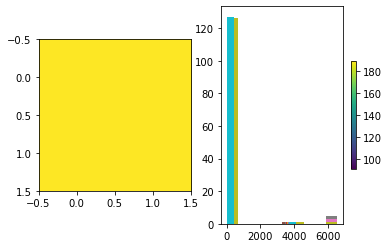

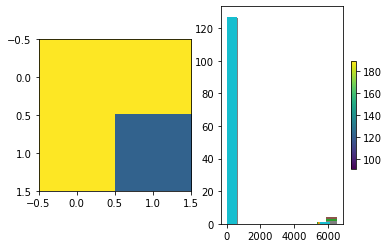

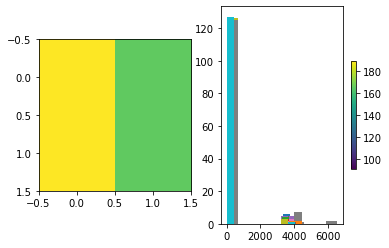

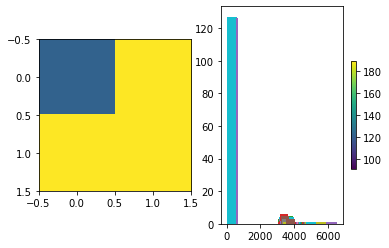

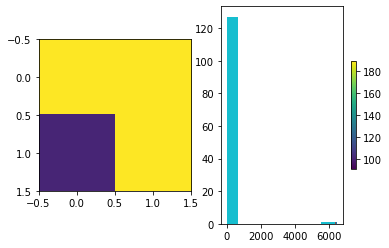

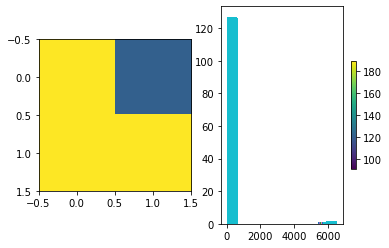

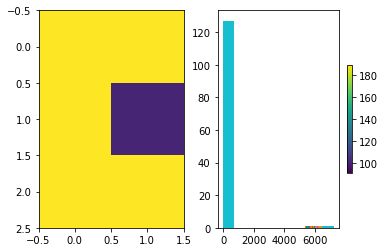

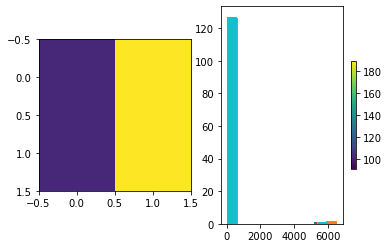

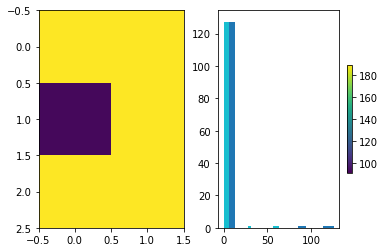

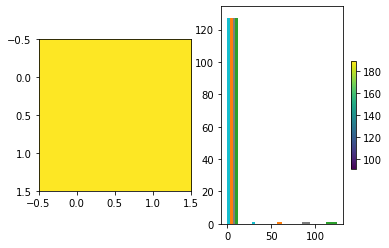

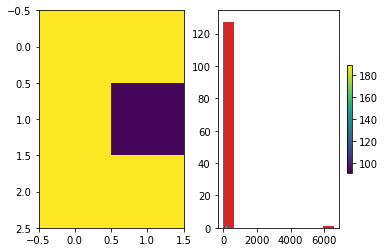

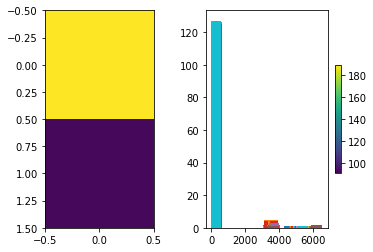

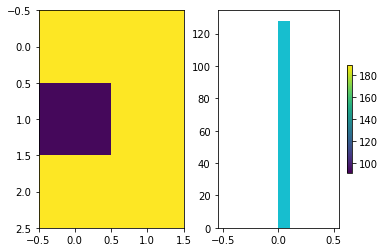

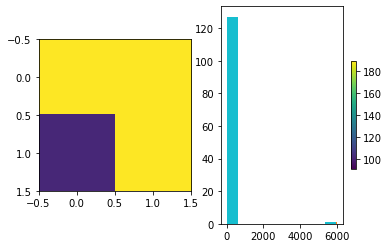

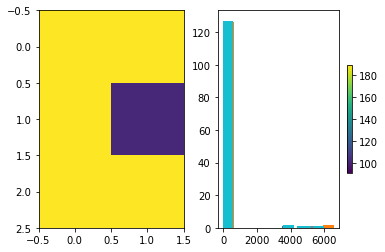

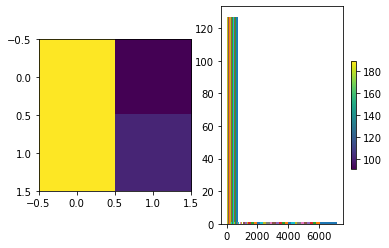

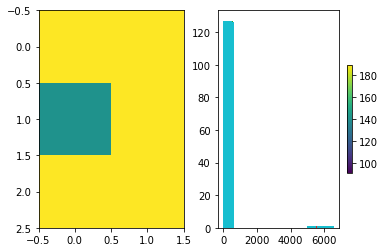

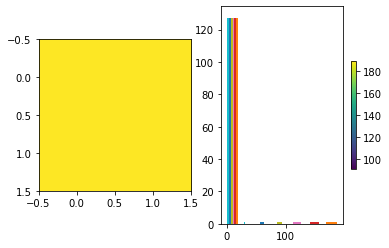

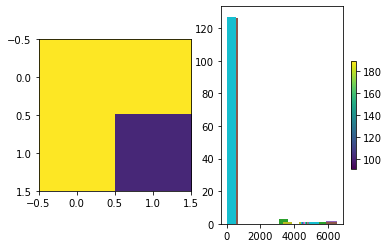

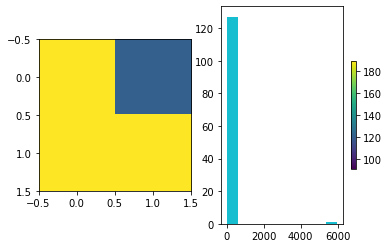

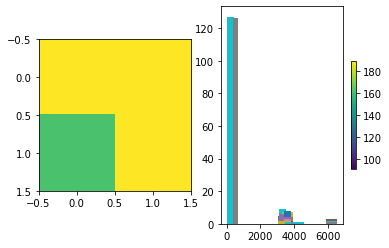

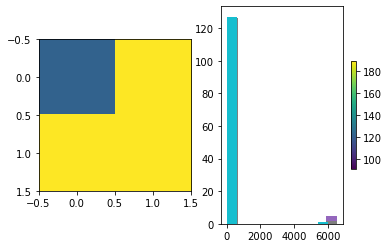

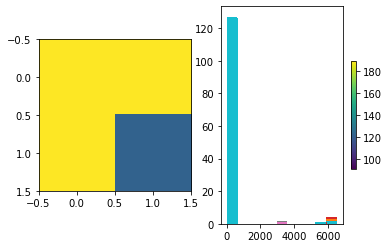

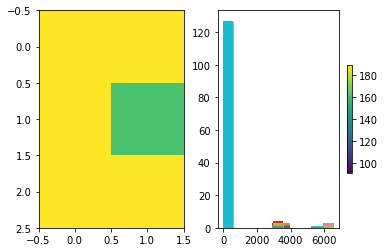

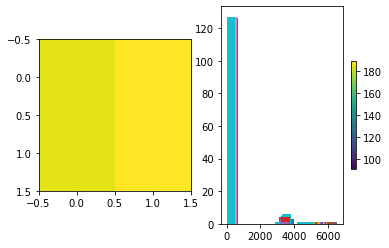

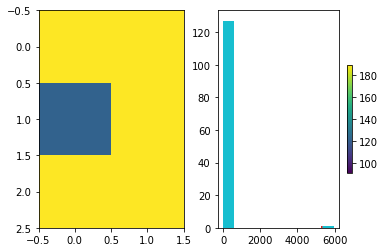

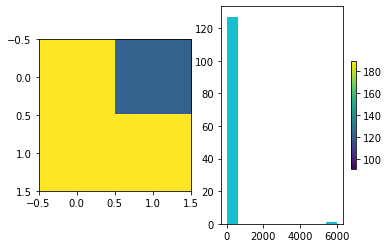

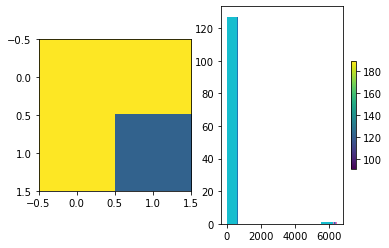

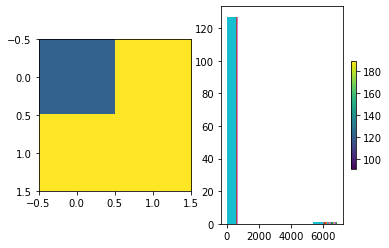

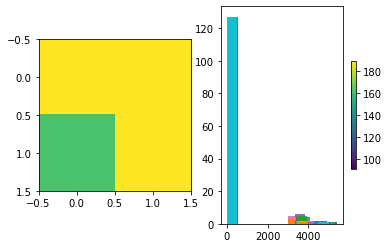

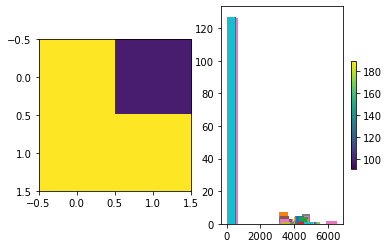

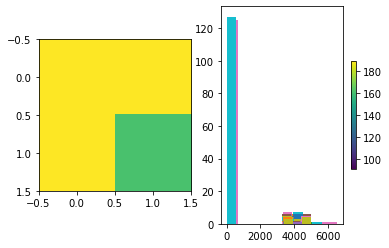

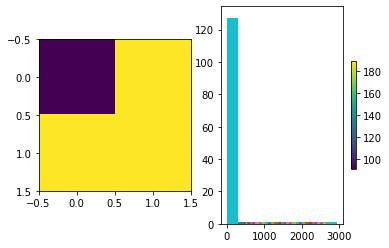

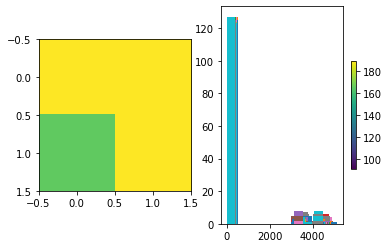

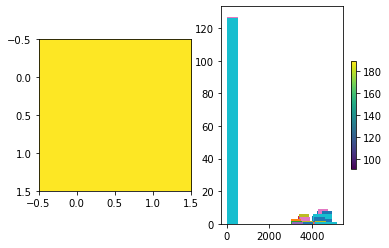

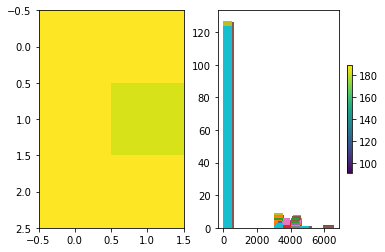

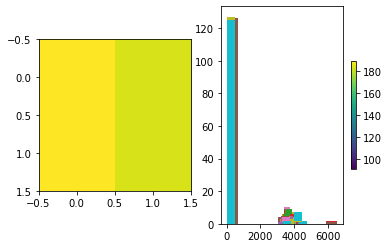

In [62]:
grass = []
forest = []
counter = 0
while (len(forest) != 10):
    print(counter)
    fuel_type = analyze_location(list_coord[counter][0], list_coord[counter][1])
    counter += 1
    if (101 <= fuel_type <= 124):
        grass.append([list_coord[counter][0], list_coord[counter][1]])
    elif (161 <= fuel_type <= 189):
        forest.append([list_coord[counter][0], list_coord[counter][1]])


In [63]:
print(len(grass))
print(len(forest))

49
10


In [65]:
from sklearn.cluster import KMeans

labels = []

X = []

for latlon in grass[:10] + forest:
    X.append(dimensionality_reduction(latlon[0], latlon[1]))
    
item = X
                  
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

for latlon in grass[:10] + forest:
    labels.append(kmeans.predict([dimensionality_reduction(latlon[0], latlon[1])])[0])


choosing tx_set/tx_96.fio
choosing tx_set/tx_96.fio
Bounding box query found in single source: nm_set/nm_103.fio
Bounding box query found in single source: nm_set/nm_103.fio
Bounding box query found in single source: nm_set/nm_103.fio
Bounding box query found in single source: nm_set/nm_103.fio
Bounding box query found in single source: nm_set/nm_103.fio
Bounding box query found in single source: nm_set/nm_88.fio
Bounding box query found in single source: nm_set/nm_88.fio
Bounding box query found in single source: nm_set/nm_88.fio
Bounding box query found in single source: nm_set/nm_103.fio
Bounding box query found in single source: nm_set/nm_9.fio
Bounding box query found in single source: co_set/co_151.fio
Bounding box query found in single source: co_set/co_135.fio
Bounding box query found in single source: co_set/co_135.fio
Bounding box query found in single source: co_set/co_103.fio
Bounding box query found in single source: co_set/co_87.fio
Bounding box query found in single sour

In [66]:
df = pd.DataFrame()
df['item'] = item#.tolist()
df['label'] = labels

import matplotlib.pyplot as plt

x = []
y = []

for i in df['item']:
    x.append(i[0])
    y.append(i[1])


df['x_val'] = x
df['y_val'] = y


filtered_label1 = df[df['label'] == 1]
filtered_label0 = df[df['label'] == 0]

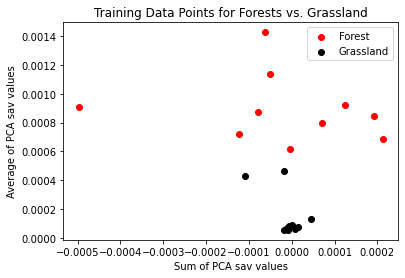

In [67]:
plt.scatter(filtered_label1['x_val'] , filtered_label1['y_val'] , color = 'red')
plt.scatter(filtered_label0['x_val'] , filtered_label0['y_val'] , color = 'black')
plt.title('Training Data Points for Forests vs. Grassland')
plt.xlabel('Sum of PCA sav values')
plt.ylabel('Average of PCA sav values')
plt.legend(['Forest', 'Grassland'])
plt.savefig('kmeans.png', bbox_inches='tight')
plt.show()

# Ignore Everything Below!!!

# KMean Implementation

In [53]:
labels = []
from sklearn.cluster import KMeans
import numpy as np
X = np.array([dimensionality_reduction(45, -122.0003),#forest
            dimensionality_reduction(32.938576, -116.684257),#grass
            dimensionality_reduction(32.885801, -116.873526),#grass
            dimensionality_reduction( 38.989042, -120.579882 ),#forest
            dimensionality_reduction( 35.19249951084869, -119.86643957481108 ),#forest
            dimensionality_reduction(43.0174, -120.2062),#grass
            dimensionality_reduction( 38.48352662411673, -123.14313953065052 ),#forest
            dimensionality_reduction( 42.808417, -119.870967 ), #grass
            dimensionality_reduction(42.92275, -113.976283),#grass
            dimensionality_reduction(44.5568, -118.8632), #forest
            dimensionality_reduction(43.683533, -122.652183),#forest
            dimensionality_reduction(47.484433, -118.94625),#grass
            dimensionality_reduction(48.096833, -121.646383),
            dimensionality_reduction(47.344283, -119.133),
            dimensionality_reduction(42.643833, -122.304883),
            dimensionality_reduction(38.296533, -80.5778)  
                 ])
item = X
                  
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
labels.append(kmeans.predict([dimensionality_reduction(45, -122.0003)])[0])#
labels.append(kmeans.predict([dimensionality_reduction(32.938576, -116.684257)])[0])#
labels.append(kmeans.predict([dimensionality_reduction(32.885801, -116.873526)])[0])#
labels.append(kmeans.predict([dimensionality_reduction( 38.989042, -120.579882 )])[0])#
labels.append(kmeans.predict([dimensionality_reduction( 35.19249951084869, -119.86643957481108 )])[0])#
labels.append(kmeans.predict([dimensionality_reduction(43.0174, -120.2062)])[0])#
labels.append(kmeans.predict([dimensionality_reduction(38.48352662411673, -123.14313953065052)])[0])#forest
labels.append(kmeans.predict([dimensionality_reduction(42.808417, -119.870967)])[0])#grassland
labels.append(kmeans.predict([dimensionality_reduction(42.92275, -113.976283)])[0])#grass scrub
labels.append(kmeans.predict([dimensionality_reduction(44.5568, -118.8632)])[0])#forest
labels.append(kmeans.predict([dimensionality_reduction(43.683533, -122.652183)])[0])#forest
labels.append(kmeans.predict([dimensionality_reduction(47.484433, -118.94625)])[0])#grass
labels.append(kmeans.predict([dimensionality_reduction(48.096833, -121.646383)])[0])#forest
labels.append(kmeans.predict([dimensionality_reduction(47.344283, -119.133)])[0])
labels.append(kmeans.predict([dimensionality_reduction(42.643833, -122.304883)])[0])
labels.append(kmeans.predict([dimensionality_reduction(38.296533, -80.5778)])[0])


Bounding box query found in single source: or_set/or_38.fio
Bounding box query found in single source: ca_set/ca_238.fio
Bounding box query found in single source: ca_set/ca_237.fio
Bounding box query found in single source: ca_set/ca_81.fio
Bounding box query found in single source: ca_set/ca_144.fio
Bounding box query found in single source: or_set/or_87.fio
Bounding box query found in single source: ca_set/ca_68.fio
Bounding box query found in single source: or_set/or_104.fio
Bounding box query found in single source: id_set/id_104.fio
Bounding box query found in single source: or_set/or_59.fio
Bounding box query found in single source: or_set/or_68.fio
Bounding box query found in single source: wa_set/wa_75.fio
Bounding box query found in single source: wa_set/wa_38.fio
Bounding box query found in single source: wa_set/wa_74.fio
Bounding box query found in single source: or_set/or_84.fio
Bounding box query found in single source: wv_set/wv_55.fio
Bounding box query found in single 

In [54]:
item.tolist()

[[2.015855352510698e-05, 7.224524597404525e-05],
 [0.001953125, 0.0],
 [0.00048828125, 0.0],
 [1.3393827430263627e-05, 9.514291741652414e-05],
 [0.001953125, 0.0],
 [0.00048828125, 0.0],
 [0.001953125, 0.0],
 [0.00048828125, 0.0],
 [-0.0001240190031239763, 0.00038911376032046974],
 [-5.4592546803178266e-06, 7.560414087492973e-05],
 [6.273056442296365e-06, 0.00010566074342932552],
 [0.00048828125, 0.0],
 [4.08596633860725e-06, 0.0001010133491945453],
 [0.00048828125, 0.0],
 [5.594893991656136e-06, 0.00010555841436143965],
 [3.314548303023912e-05, 8.114573574857786e-05]]

In [55]:
labels

[0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [56]:
df = pd.DataFrame()
df['item'] = item.tolist()
df['label'] = labels

In [57]:
import matplotlib.pyplot as plt
 
x = []
y = []
for i in df['item']:
    x.append(i[0])
    y.append(i[1])

df['x_val'] = x
df['y_val'] = y

filtered_label1 = df[df['label'] == 1]
filtered_label0 = df[df['label'] == 0]

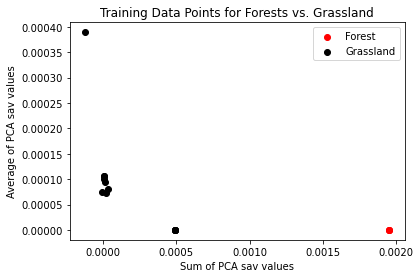

In [58]:
plt.scatter(filtered_label1['x_val'] , filtered_label1['y_val'] , color = 'red')
plt.scatter(filtered_label0['x_val'] , filtered_label0['y_val'] , color = 'black')
plt.title('Training Data Points for Forests vs. Grassland')
plt.xlabel('Sum of PCA sav values')
plt.ylabel('Average of PCA sav values')
plt.legend(['Forest', 'Grassland'])
plt.savefig('kmeans.png', bbox_inches='tight')
plt.show()

In [59]:
plt.close()

Rough Summary

0 = Water

~1 = Urban

~1-1k = Desert (Depends on the amount of dry plants in a desert)

~6k = Grass/Shrub

~7k-10k = Forest

Rough Summary 1/11/2022: if the histogram is not a bimodal distribution, then the data could be used to determine its geographical features.

Observation: most of the forests have a right skew distribution for their sav height values.

Rough Summary 1/11/2022: if the histogram is not a bimodal distribution, then the data could be used to determine its geographical features.

Observation: most of the forests have a right skew distribution for their sav height values.

Rough Summary 2/1/2022:

Implement a general clustering algorithm, more training data is needed (construct an automation so there's a faster way to extract training data).